<a href="https://colab.research.google.com/github/MarinaChau/IASD_classes/blob/master/Criteo/Module5_TP_FV_Siamese_2022_perso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face verification using Siamese Networks

### Goals
- train a network for face similarity using siamese networks
- work data augmentation, generators and hard negative mining
- use the model on your picture


### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at http://vis-www.cs.umass.edu/lfw/
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU, by setting `USE_SUBSET=False` in the following cells,
- We will also load pretrained weights


In [ ]:
%tensorflow_version 2.x

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import tensorflow as tf

In [ ]:
import os
import random
import itertools

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Lambda, Dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Processing the dataset

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

In [ ]:
%%capture

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xvzf lfw-deepfunneled.tgz

In [ ]:
PATH = "lfw-deepfunneled/"
USE_SUBSET = True

In [ ]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = np.random.choice(dirs, 500, False)

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("number of classes: ", num_classes)

number of classes:  500


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [ ]:
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}

In [ ]:
# build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items())[0:13])

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 5,
 10: 6,
 11: 7,
 12: 8}

The following histogram shows the number of images per class: there are many classes with only one image. 
These classes are useful as negatives, only as we can't make a positive pair with them.

In [ ]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('Jacques_Chirac', 52),
 ('Carlos_Menem', 21),
 ('John_Howard', 19),
 ('Abdullah_Gul', 19),
 ('Julianne_Moore', 19),
 ('Nicole_Kidman', 19),
 ('Norah_Jones', 15),
 ('Nancy_Pelosi', 15),
 ('Kim_Clijsters', 14),
 ('Roger_Federer', 14)]

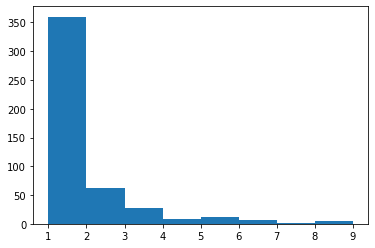

In [ ]:
plt.hist([len(v) for k,v in classid_to_ids.items()], bins=range(1,10))
plt.show()

### Siamese nets

A siamese net takes as input two images $x_1$ and $x_2$ and outputs a single value which corresponds to the similarity between $x_1$ and $x_2$.

In order to train such a system, one has to build positive and negative pairs for the training. 

In [ ]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    
    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [ ]:
# build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
        
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
        
    return neg_pairs

Let's build positive and a negative pairs for class 5

In [ ]:
build_pos_pairs_for_id(5, 20)

[]

In [ ]:
build_neg_pairs_for_id(5, list(range(num_classes)), 6)

[(9, 390), (9, 821), (9, 39), (9, 153), (9, 26), (9, 122)]

Now that we have a way to compute the pairs, let's open all the possible images. It will expand all the images into RAM memory. There are more than 1000 images, so 100Mo of RAM will be used, which will not cause any issue.

_Note: if you plan on opening more images, you should not open them all at once, and rather build a generator_

In [ ]:
from skimage.io import imread
from skimage.transform import resize


def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]


def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)),0)]
    return np.vstack(all_imgs)

In [ ]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape

(1036, 60, 60, 3)

In [ ]:
str(all_imgs.nbytes / 1e6) + "MB"

'89.5104MB'

The following function builds a large number of positives/negatives pairs (train and test)

In [ ]:
def build_train_test_data(split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for class_id in range(split):
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

In [ ]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data()

In [ ]:
X1_ids_train.shape, X2_ids_train.shape, train_Y.shape

((2234,), (2234,), (2234,))

In [ ]:
np.mean(train_Y)

0.5

In [ ]:
X1_ids_test.shape, X2_ids_test.shape, test_Y.shape

((596,), (596,), (596,))

In [ ]:
np.mean(test_Y)

0.5

**Data augmentation and generator**

We're building a generator, which will modify images through dataaugmentation on the fly. 
The generator enables
We use iaa library which offers tremendous possibilities for data augmentation


In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # You can add more transformation like random rotations, random change of luminance, etc.
])

In [ ]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs1 = seq.augment_images(self.imgs[self.X1[low_index:high_index]])
        imgs2 = seq.augment_images(self.imgs[self.X2[low_index:high_index]])
        targets = self.Y[low_index:high_index]
    
        return ([imgs1, imgs2], targets)

In [ ]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

In [ ]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 69


In [ ]:
[x1, x2], y = gen[0]

x1.shape, x2.shape, y.shape

((32, 60, 60, 3), (32, 60, 60, 3), (32,))

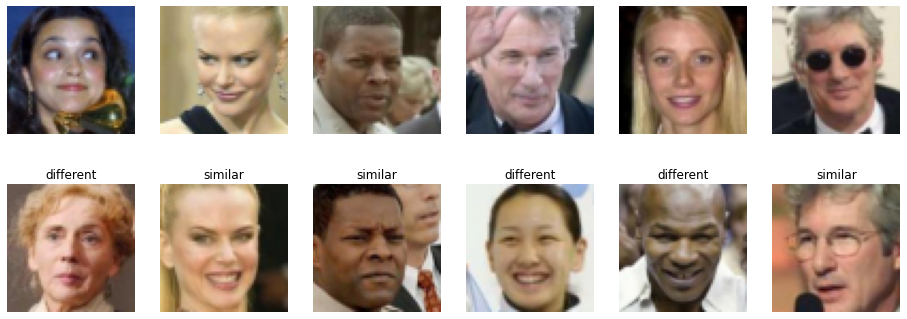

In [ ]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
    
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
    
plt.show()

**Exercise**
- Add your own dataaugmentations in the process. You may look at: http://imgaug.readthedocs.io for instance use `iaa.Affine`;
- Be careful not to make the task to difficult, and to add meaningful augmentations;
- Rerun the generator plot above to check whether the image pairs look not too distorted to recognize the identities.

** Test images **

- In addition to our generator, we need test images, unaffected by the augmentation

In [ ]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [ ]:
test_X1.shape, test_X2.shape, test_Y.shape

((596, 60, 60, 3), (596, 60, 60, 3), (596,))

## Simple convolutional model

In [ ]:

def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [ ]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

**Exercise**
- Build a convolutional model which transforms the input to a fixed dimension $d = 50$
- You may alternate convolutions and maxpooling and layers,
- Use the relu activation on convolutional layers,
- At the end, `Flatten` the last convolutional output and plug it into a dense layer.
- Feel free to use some `Dropout` prior to the Dense layer.

Use between 32 and 128 channels on convolutional layers. Be careful: large convolutions on high dimensional images can be very slow on CPUs.

Try to run your randomly initialized `shared_conv`  model on a batch of the first 10 images from `all_imgs`. What is the expected shape of the output?

In [ ]:
class SharedConv(tf.keras.Model):
    def __init__(self):
        super().__init__(self, name="sharedconv")
        self.conv1 = Conv2D(filters=128, kernel_size=(8, 8), strides=(4, 4))
        self.conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2))
        self.conv3 = Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1))
        self.flatten = Flatten()
        self.dense = Dense(units=50, activation=tf.nn.sigmoid)
        
    def call(self, inputs):
        net = self.conv1(inputs)
        net = tf.nn.relu(net)
        net = self.conv2(net)
        net = tf.nn.relu(net)
        net = self.conv3(net)
        net = tf.nn.relu(net)
        net = self.flatten(net)
        net = self.dense(net)
        return net
        
shared_conv = SharedConv()

In [ ]:
all_imgs.shape

(1036, 60, 60, 3)

In [ ]:
shared_conv.predict(all_imgs[:10]).shape

(10, 50)

In [ ]:
shared_conv.summary()

Model: "sharedconv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  24704     
                                                                 
 conv2d_1 (Conv2D)           multiple                  131136    
                                                                 
 conv2d_2 (Conv2D)           multiple                  8200      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3650      
                                                                 
Total params: 167,690
Trainable params: 167,690
Non-trainable params: 0
_________________________________________________________________


**Exercise**

Assemble the siamese model by combining:

- `shared_conv` on both inputs;
- compute the cosine similarity using the [Dot](https://keras.io/layers/merge/#dot) layer with `normalize=True` on the outputs of the two `shared_conv` instance lanes;
- the loss of siamese model is the constrastive loss defined previously;
- use the `accuracy_sim` function defined previously as a metric.
    

In [ ]:
class Siamese(tf.keras.Model):
    def __init__(self, shared_conv):
        super().__init__(self, name="siamese")
        self.shared_conv = shared_conv
        self.dot = Dot(normalize=True, axes=1)
        
    def call(self, inputs):
        
        out1 = self.shared_conv(inputs[0])
        out2 = self.shared_conv(inputs[1])
        
        dot = self.dot([out1, out2])
        
        return dot

model = Siamese(shared_conv)
model.compile(loss=contrastive_loss, optimizer='rmsprop', metrics=[accuracy_sim])

We can now fit the model and checkpoint it to keep the best version. We can expect to get a model with around 0.75 as "accuracy_sim" on the validation set:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


best_model_fname = "siamese_checkpoint"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, verbose=1)

In [ ]:
model.fit_generator(generator=gen, 
                    epochs=15,
                    validation_data=([test_X1, test_X2], test_Y),
                    callbacks=[best_model_cb], verbose=2)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.



Epoch 1: val_accuracy_sim improved from -inf to 0.50000, saving model to siamese_checkpoint
INFO:tensorflow:Assets written to: siamese_checkpoint/assets
69/69 - 11s - loss: 0.2123 - accuracy_sim: 0.5032 - val_loss: 0.1863 - val_accuracy_sim: 0.5000 - 11s/epoch - 156ms/step
Epoch 2/15

Epoch 2: val_accuracy_sim improved from 0.50000 to 0.50164, saving model to siamese_checkpoint
INFO:tensorflow:Assets written to: siamese_checkpoint/assets
69/69 - 9s - loss: 0.1676 - accuracy_sim: 0.5100 - val_loss: 0.2764 - val_accuracy_sim: 0.5016 - 9s/epoch - 126ms/step
Epoch 3/15

Epoch 3: val_accuracy_sim improved from 0.50164 to 0.50329, saving model to siamese_checkpoint
INFO:tensorflow:Assets written to: siamese_checkpoint/assets
69/69 - 9s - loss: 0.1709 - accuracy_sim: 0.5082 - val_loss: 0.1572 - val_accuracy_sim: 0.5033 - 9s/epoch - 128ms/step
Epoch 4/15

Epoch 4: val_accuracy_sim did not improve from 0.50329
69/69 - 8s - loss: 0.1571 - accuracy_sim: 0.5190 - val_loss: 0.1643 - val_accuracy_s

In [ ]:
model.summary()

Model: "siamese"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sharedconv (SharedConv)     multiple                  167690    
                                                                 
 dot (Dot)                   multiple                  0         
                                                                 
Total params: 167,690
Trainable params: 167,690
Non-trainable params: 0
_________________________________________________________________


**Exercise**

Finding the most similar images

- Run the shared_conv model on all images;
- (Optional) add Charles and Olivier's faces from the `test_images` folder to the test set;
- build a `most_sim` function which returns the most similar vectors to a given vector.

In [ ]:
# TODO

my_dot = Dot(normalize=True, axes=1)

emb = shared_conv(all_imgs)

def most_sim(x, emb, topn=3):
    x_e = tf.expand_dims(x, axis=0)
    
    best_candidates_with_scores = list()
    
    for i, candidate in enumerate(emb):
        c_e = tf.expand_dims(candidate, axis=0)
        sim = float(my_dot([x_e, c_e]))
        
        best_candidates_with_scores.append((i, sim))
        best_candidates_with_scores = sorted(best_candidates_with_scores, key=lambda s: s[1])[-topn:]
        
    return best_candidates_with_scores

** Most similar faces **

The following enables to display an image alongside with most similar images:

- The results are weak, first because of the size of the dataset
- Also, the network can be greatly improved

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

query: Roger_Federer 636
nearest matches
James_Cameron 1033 1.0000001192092896


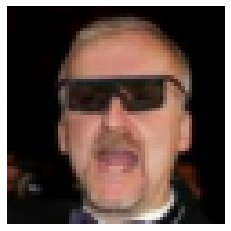

James_Cameron 1034 1.0000001192092896


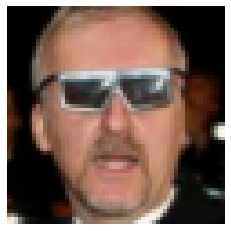

James_Cameron 1035 1.0000001192092896


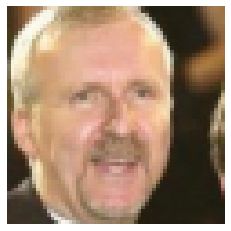

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
class_id = random.choice(interesting_classes)[0]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
# display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim(emb[query_id], emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)    
    display(all_imgs[result_id])

Note that this model is still underfitting, even when running queries against the training set. Even if the results are not correct, the mistakes often seem to "make sense" though.

Running a model to convergence on higher resolution images, possibly with a deeper and wider convolutional network might yield better results. In the next notebook we will try with a better loss and with hard negative mining.

**Playing with the camera**
- The following code enables you to find the most similar faces to yours
- What do you observe?
- Try to think of reasons why it doesn't work very well, and how you could improve it.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

AbortError: Starting videoinput failed


In [ ]:
import matplotlib.image as mpimg

image=mpimg.imread('photo.jpg')

FileNotFoundError: ignored

In [ ]:
x = resize100(image)
out = shared_conv(np.reshape(x, (1, 60, 60, 3)))
print("query image:")
#display(x)
for id, sim in most_sim(out[0], emb, topn=10):
    class_name = classid_to_name.get(id_to_classid.get(id))
    if class_name is None:
        print(id)
    print(class_name, id, sim)

query image:
Andy_Wisecarver 637 0.8841004371643066
Armando_Avila_Panchame 898 0.8841004371643066
Ben_Wallace 1133 0.8943326473236084
Ben_Affleck 1113 0.8972707986831665
Alain_Ducasse 181 0.9023312330245972
Albaro_Recoba 207 0.9023312330245972
Antonio_Palocci 773 0.9023312330245972
Ben_Affleck 1109 0.9023312330245972
Al_Pacino 172 0.9165691137313843
Alan_Zemaitis 198 0.9382871389389038
